

# Workshop de Spark

Cargamos un dataset con información de una campaña de marketing portuguesa para la venta de un préstamo bancario. El objetivo es, una vez limpiado el dataset, estudiarlo para extraer el máximo número de insights de los datos.

#Configuración  
##Adaptamos notebook para la ejecución de Spark desde Colaboratory

In [0]:
# Global data variables
SANDBOX_NAME = "fesc"
DATA_PATH = "/content/drive/My Drive/" 

In [0]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.2.1-bin-hadoop2.7"

In [0]:
import findspark
findspark.init()
from pyspark.sql import SparkSession

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
spark = SparkSession.builder.master("local[*]").getOrCreate()

## Importación de funciones necesarias


In [0]:
from pyspark.sql import functions as F

In [0]:
from matplotlib import pyplot as plt
import seaborn as sns

%matplotlib inline

In [0]:
import pandas as pd

In [0]:
from pyspark.mllib.linalg import Vectors
from pyspark.mllib.stat import Statistics

In [0]:
from pyspark.sql.functions import concat, lit 



## Lectura de datos

** Leemos el archivo bank-full.csv**

(indicamos el delimitador, que es un ; y cargamos cabeceras y esquema)




In [0]:
bank = spark.read.csv(DATA_PATH+'bank-full.csv', sep=';',header=True, inferSchema=True)


**Creamos una copia**, llamada bank_b para para poder manipular la bank sin perder nada.

In [0]:
bank_b=bank
bank_b.show(1)

+---+----------+-------+---------+-------+-------+-------+----+-------+---+-----+----+--------+--------+-----+--------+--------+---+--------------+----------+
|age|       job|marital|education|default|balance|housing|loan|contact|day|month|year|duration|campaign|pdays|previous|poutcome|  y|picked_up_call|extra_info|
+---+----------+-------+---------+-------+-------+-------+----+-------+---+-----+----+--------+--------+-----+--------+--------+---+--------------+----------+
| 58|management|married| tertiary|     no|   2143|    yes|  no|unknown|  5|  may|2008|     261|       1|   -1|       0| unknown| no|             1|         1|
+---+----------+-------+---------+-------+-------+-------+----+-------+---+-----+----+--------+--------+-----+--------+--------+---+--------------+----------+
only showing top 1 row



# Estudio de la información básica de DataFrame

##Previsualización

In [0]:
bank.show(3)

+---+------------+-------+---------+-------+-------+-------+----+-------+---+-----+----+--------+--------+-----+--------+--------+---+--------------+----------+
|age|         job|marital|education|default|balance|housing|loan|contact|day|month|year|duration|campaign|pdays|previous|poutcome|  y|picked_up_call|extra_info|
+---+------------+-------+---------+-------+-------+-------+----+-------+---+-----+----+--------+--------+-----+--------+--------+---+--------------+----------+
| 58|  management|married| tertiary|     no|   2143|    yes|  no|unknown|  5|  may|2008|     261|       1|   -1|       0| unknown| no|             1|         1|
| 44|  technician| single|secondary|     no|     29|    yes|  no|unknown|  5|  may|2008|     151|       1|   -1|       0| unknown| no|             1|         1|
| 33|entrepreneur|married|secondary|     no|      2|    yes| yes|unknown|  5|  may|2008|      76|       1|   -1|       0| unknown| no|             1|         1|
+---+------------+-------+--------

## Dimensiones

Se leen y almacenan.

In [0]:
dimensiones= {"filas ":bank.count(),"columnas ":len(bank.columns)}
dimensiones

{'columnas ': 20, 'filas ': 45211}

##Estructura de los datos

In [0]:
bank.printSchema()
#Consideramos que es suficiente información sobre los tipos. No hacemos dTypes.

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- day: integer (nullable = true)
 |-- month: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- y: string (nullable = true)
 |-- picked_up_call: integer (nullable = true)
 |-- extra_info: integer (nullable = true)



# Renombrado de variables





Los nombres están correctamente escritos por lo que a buenas prácticas se refiere.

Sin embargo, resolvemos cambiar algunas de las columnas puesto que los nombres originales no dan ninguna pista del contenido. AsÍ

*   marital --> marital_status
*   housing --> mortgage
*   y -->subscribed
*   campaign-->number_of_contacts






In [0]:
bank=bank.withColumnRenamed('marital', 'marital_status')\
.withColumnRenamed('housing', 'mortgage')\
.withColumnRenamed('campaign', 'number_of_contacts')\
.withColumnRenamed('y', 'subscribed')
bank.show(1)

+---+----------+--------------+---------+-------+-------+--------+----+-------+---+-----+----+--------+------------------+-----+--------+--------+----------+--------------+----------+
|age|       job|marital_status|education|default|balance|mortgage|loan|contact|day|month|year|duration|number_of_contacts|pdays|previous|poutcome|subscribed|picked_up_call|extra_info|
+---+----------+--------------+---------+-------+-------+--------+----+-------+---+-----+----+--------+------------------+-----+--------+--------+----------+--------------+----------+
| 58|management|       married| tertiary|     no|   2143|     yes|  no|unknown|  5|  may|2008|     261|                 1|   -1|       0| unknown|        no|             1|         1|
+---+----------+--------------+---------+-------+-------+--------+----+-------+---+-----+----+--------+------------------+-----+--------+--------+----------+--------------+----------+
only showing top 1 row



# Estudio de valores nulos

Miramos qué porcentaje de nulos hay por cada variable

In [0]:
n_rows_bank = bank.count()
missing_ops = [F.round(F.sum(F.col(c).isNull().cast('int')) * 100 / n_rows_bank, 2).alias(c) 
               for c in bank.columns]

bank.select(missing_ops).show()



+---+---+--------------+---------+-------+-------+--------+----+-------+---+-----+----+--------+------------------+-----+--------+--------+----------+--------------+----------+
|age|job|marital_status|education|default|balance|mortgage|loan|contact|day|month|year|duration|number_of_contacts|pdays|previous|poutcome|subscribed|picked_up_call|extra_info|
+---+---+--------------+---------+-------+-------+--------+----+-------+---+-----+----+--------+------------------+-----+--------+--------+----------+--------------+----------+
|0.0|0.0|           0.0|      0.0|    0.0|    0.0|     0.0| 0.0|    0.0|0.0|  0.0| 0.0|     0.0|               0.0|  0.0|     0.0|     0.0|       0.0|           0.0|     99.83|
+---+---+--------------+---------+-------+-------+--------+----+-------+---+-----+----+--------+------------------+-----+--------+--------+----------+--------------+----------+



Nulos, como tales, solo hay en la columna extra_info, cuyo significado no vemos documentado en la web.

Veremos los valores de la variable extra_info para decidir si procede eliminarla.

In [0]:
bank.groupBy('extra_info').count().show()

+----------+-----+
|extra_info|count|
+----------+-----+
|      null|45133|
|         1|   73|
|        11|    5|
+----------+-----+



In [0]:
bank.filter(F.col('extra_info') >0).show(12) 

#Se ha puesto este filtro para mirar los datos que aparecen cuando extra_info es no nulo.

+---+------------+--------------+---------+-------+-------+--------+----+-------+---+-----+----+--------+------------------+-----+--------+--------+----------+--------------+----------+
|age|         job|marital_status|education|default|balance|mortgage|loan|contact|day|month|year|duration|number_of_contacts|pdays|previous|poutcome|subscribed|picked_up_call|extra_info|
+---+------------+--------------+---------+-------+-------+--------+----+-------+---+-----+----+--------+------------------+-----+--------+--------+----------+--------------+----------+
| 58|  management|       married| tertiary|     no|   2143|     yes|  no|unknown|  5|  may|2008|     261|                 1|   -1|       0| unknown|        no|             1|         1|
| 44|  technician|        single|secondary|     no|     29|     yes|  no|unknown|  5|  may|2008|     151|                 1|   -1|       0| unknown|        no|             1|         1|
| 33|entrepreneur|       married|secondary|     no|      2|     yes| y

Visto que es un entero con 2 valores y que la mayoría están en blanco, creemos que no aporta nada y la borramos.

In [0]:
bank=bank.drop('extra_info')
bank.show(3)

+---+------------+--------------+---------+-------+-------+--------+----+-------+---+-----+----+--------+------------------+-----+--------+--------+----------+--------------+
|age|         job|marital_status|education|default|balance|mortgage|loan|contact|day|month|year|duration|number_of_contacts|pdays|previous|poutcome|subscribed|picked_up_call|
+---+------------+--------------+---------+-------+-------+--------+----+-------+---+-----+----+--------+------------------+-----+--------+--------+----------+--------------+
| 58|  management|       married| tertiary|     no|   2143|     yes|  no|unknown|  5|  may|2008|     261|                 1|   -1|       0| unknown|        no|             1|
| 44|  technician|        single|secondary|     no|     29|     yes|  no|unknown|  5|  may|2008|     151|                 1|   -1|       0| unknown|        no|             1|
| 33|entrepreneur|       married|secondary|     no|      2|     yes| yes|unknown|  5|  may|2008|      76|                 1| 

# Contenido de las variables

Antes de mirar formatos, comprobamos el contenido (frecuencias) de cada variable para determinar:
- Si hay muchos valores repetidos y la variable no aporta nada
- Si hay falsos nulos
- Si hay alguna variable con valores incongruentes.

También tendremos información para pasar a Boolean las variables de doble estado, si las hay.

Estas son las frecuencias:

In [0]:
for col in bank.columns:
  bank.groupBy(F.col(col)).count().show()

+---+-----+
|age|count|
+---+-----+
| 31| 1996|
| 85|    5|
| 65|   59|
| 53|  891|
| 78|   30|
| 34| 1930|
| 81|   17|
| 28| 1038|
| 76|   32|
| 27|  909|
| 26|  805|
| 44| 1136|
| 22|  129|
| 93|    2|
| 47| 1088|
| 52|  911|
| 86|    9|
| 40| 1355|
| 20|   50|
| 94|    1|
+---+-----+
only showing top 20 rows

+-------------+-----+
|          job|count|
+-------------+-----+
|   management| 9458|
|      retired| 2264|
|      unknown|  288|
|self-employed| 1579|
|      student|  938|
|  blue-collar| 9732|
| entrepreneur| 1487|
|       admin.| 5171|
|   technician| 7597|
|     services| 4154|
|    housemaid| 1240|
|   unemployed| 1303|
+-------------+-----+

+--------------+-----+
|marital_status|count|
+--------------+-----+
|      divorced| 5207|
|       married|27214|
|        single|12790|
+--------------+-----+

+---------+-----+
|education|count|
+---------+-----+
|  unknown| 1857|
| tertiary|13301|
|secondary|23202|
|  primary| 6851|
+---------+-----+

+-------+-----+
|default|c

**Conclusiones:**

A cambiar:
- La variable picked_up_call solo tiene 3 valores a 0, y 45.208 a 1. Interpretamos que si no hay llamada, no tiene sentido conservar estas filas. Se eliminan.
- El (contact) medio de contacto y el poutcome tiene la mayoría a unknown, que no es un valor posible registrado en la web. Se pone a null.

A mantener:
- La variable default tiene casi todos los valores a No. Nos parece correcto (la mayoría de contactados no tiene deuda).
- En las variables job y education sí que se registra como valor de respuesta posible unknown. Se dejan así.

Comentario adicional:
Las variables con contenido "yes"/"no" se ven sin nulos ni falsos nulos.






Eliminamos los registros con picked_up= 0.

A continuación eliminamos la columna

In [0]:
bank=bank.filter(F.col('picked_up_call') != 0)


In [0]:
bank=bank.drop('picked_up_call')
dimensiones2={"filas ":bank.count(),"columnas ":len(bank.columns)}
print("dimensión original:  ",dimensiones)
print("dimensión actual  :  ",dimensiones2)

dimensión original:   {'filas ': 45211, 'columnas ': 20}
dimensión actual  :   {'filas ': 45208, 'columnas ': 18}


(Vemos 2 columnas menos: extra_info y picked_up_call)

Ponemos los unknown de poutcome y contact a None.

Mostramos el resultado

In [0]:
bank=bank.withColumn('poutcome',F.when(F.col('poutcome') == 'unknown', 'None').otherwise(F.col('poutcome')))
bank=bank.withColumn('contact',F.when(F.col('contact') == 'unknown', 'None').otherwise(F.col('poutcome')))
bank.groupBy(F.col('poutcome')).count().show()
bank.groupBy(F.col('contact')).count().show()

+--------+-----+
|poutcome|count|
+--------+-----+
|    None|36958|
| success| 1510|
|   other| 1839|
| failure| 4901|
+--------+-----+

+-------+-----+
|contact|count|
+-------+-----+
|   None|37028|
|success| 1498|
|  other| 1812|
|failure| 4870|
+-------+-----+



En cuanto a valores erróneos (antes de tratar outliers), vemos que solo age podría presentar alguno. Estudiamos máximo y mínimo.

In [0]:
bank.agg(F.max('age'),F.min('age')).show()

+--------+--------+
|max(age)|min(age)|
+--------+--------+
|      95|      18|
+--------+--------+



No hay que tocar nada en las edades.

# Formato de las variables

No vemos nada que esté demasiado desajustado.
Sin embargo, creemos conveniente:

a) Pasar a boolean las variables que tienen dos estados:
*   default
*   loan
*   mortgage

b) subscribed no se convierte a boolean sino a integer porque el valor 1,0 nos irá mejor para la correlación final.

c) Crear una fecha en formato de fecha real (datetime) por si hay que hacer cálculos (la que viene en el archivo es poco manejable).

##a) Pasamos a boolean: default, loan, mortgage
Creamos una lista con las variables de doble estado que queremos pasar a boolean y iteramos para cada columna que coincide con la variable de la lista, para cambiar Yes/No a True/False.

In [0]:
camposYN=['default','loan','mortgage']


In [0]:
for x in camposYN:
  bank=bank.withColumn(x,F.when(F.col(x) == 'yes', True).otherwise(False))

##b) Pasamos subscribed a 1,0

In [0]:
bank=bank.withColumn('subscribed',F.when(F.col('subscribed') == 'yes', 1).otherwise(0))
bank=bank.withColumn('subscribed',F.col('subscribed').cast('int'))


In [0]:
bank.printSchema() #Al dar valores True/False no hace falta el cast.Ya son boolean:

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital_status: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: boolean (nullable = false)
 |-- balance: integer (nullable = true)
 |-- mortgage: boolean (nullable = false)
 |-- loan: boolean (nullable = false)
 |-- contact: string (nullable = true)
 |-- day: integer (nullable = true)
 |-- month: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- duration: integer (nullable = true)
 |-- number_of_contacts: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- subscribed: integer (nullable = false)



## c) Creamos un campo de fecha

In [0]:
# Paso 1: hacemos un cast a "string" de los dos campos numéricos: day, year

bank = bank.withColumn('day_str', (F.col('day')).cast('string')).withColumn('year_str', (F.col('year')).cast('string'))

In [0]:
#Paso 2 concatenamos a un único campo de fecha en string
bank = bank.select('*',concat(bank['day_str'], bank['month'],bank['year_str']).alias('date')) 


In [0]:
#Paso 3 pasamos a fecha numérica la fecha en string
bank=bank.withColumn('date',F.to_date(F.col('date'),'ddMMMyyyy'))

In [0]:
#Paso 4 borramos las columnas de texto de día y año que habíamos creado
bank = bank.drop('day_str', 'year_str')
bank.show(3)

+---+------------+--------------+---------+-------+-------+--------+-----+-------+---+-----+----+--------+------------------+-----+--------+--------+----------+----------+
|age|         job|marital_status|education|default|balance|mortgage| loan|contact|day|month|year|duration|number_of_contacts|pdays|previous|poutcome|subscribed|      date|
+---+------------+--------------+---------+-------+-------+--------+-----+-------+---+-----+----+--------+------------------+-----+--------+--------+----------+----------+
| 58|  management|       married| tertiary|  false|   2143|    true|false|   None|  5|  may|2008|     261|                 1|   -1|       0|    None|         0|2008-05-05|
| 44|  technician|        single|secondary|  false|     29|    true|false|   None|  5|  may|2008|     151|                 1|   -1|       0|    None|         0|2008-05-05|
| 33|entrepreneur|       married|secondary|  false|      2|    true| true|   None|  5|  may|2008|      76|                 1|   -1|       0|

# Registros duplicados

Eliminamos duplicados puros en un conjunto aparte (llamado prueba) y comparamos el recuento.


In [0]:
bank.count()

45208

In [0]:
prueba=bank.dropDuplicates()
prueba.count()


45208

 **No hay duplicados puros.**
Al no haber ningún campo clave o id, no vemos sentido a estudiar duplicados parciales.

# Variables derivadas

Creamos una variable derivada por **tramos de edad**, para hacer estudios por grupos.

In [0]:
bank=bank.withColumn('age_range',F.when(F.col('age') >=65, '[65...)')\
                             .when(F.col('age') >= 50, '[50 - 65)')\
                             .when(F.col('age') >= 35, '[35 - 50)')\
                             .when(F.col('age') >= 20, '[20 - 35)')\
                               .otherwise('[20 - 35)'))
bank.select('age','age_range').show(5)


+---+---------+
|age|age_range|
+---+---------+
| 58|[50 - 65)|
| 44|[35 - 50)|
| 33|[20 - 35)|
| 47|[35 - 50)|
| 33|[20 - 35)|
+---+---------+
only showing top 5 rows



# Análisis estadístico de variables


Separamos variables cuantitativas de cualitativas




In [0]:
cuantitativas = [c for c,t in bank.dtypes if t in ['int', 'double']]
cualitativas = [c for c,t in bank.dtypes if t in ['string']] #No miraremos booleanas
print(cuantitativas, cualitativas)

['age', 'balance', 'day', 'year', 'duration', 'number_of_contacts', 'pdays', 'previous', 'subscribed'] ['job', 'marital_status', 'education', 'contact', 'month', 'poutcome', 'age_range']


Hay variables que no tiene demasiado sentido analizar: day, year, month. Las quitamos de las listas respectivas.

In [0]:
cuantitativas.pop(2)
cuantitativas.pop(2)
cualitativas.pop(4)
print(cuantitativas, cualitativas)

['age', 'balance', 'duration', 'number_of_contacts', 'pdays', 'previous', 'subscribed'] ['job', 'marital_status', 'education', 'contact', 'poutcome', 'age_range']


##Magnitudes descriptivas para las variables numéricas

1. Recuento, media, desviación, máximo y mínimo:

In [0]:
bank.describe(cuantitativas).show()

+-------+------------------+------------------+------------------+------------------+-----------------+------------------+------------------+
|summary|               age|           balance|          duration|number_of_contacts|            pdays|          previous|        subscribed|
+-------+------------------+------------------+------------------+------------------+-----------------+------------------+------------------+
|  count|             45208|             45208|             45208|             45208|            45208|             45208|             45208|
|   mean| 40.93525482215537|1362.1555476906742|258.13605998938243| 2.763780746770483|40.19228897540258|0.5800522031498849|0.1169704477083702|
| stddev|10.617824306235486|3044.7868793873704| 257.5007991852839| 3.098098285888155|100.1271834207721|2.3029663705620314|0.3213886227889667|
|    min|                18|             -8019|                 0|                 1|               -1|                 0|                 0|
|    m

2. Mediana

In [0]:
median=dict()
for x in cuantitativas:
  median[x]=bank.approxQuantile(x,[0.5], relativeError=0.01)[0]
median

{'age': 39.0,
 'balance': 441.0,
 'duration': 179.0,
 'number_of_contacts': 2.0,
 'pdays': -1.0,
 'previous': 0.0,
 'subscribed': 0.0}

3. Cuantiles

In [0]:
cuantiles=dict()
for x in cuantitativas:
  cuantiles[x]=bank.approxQuantile(x,[0.25, 0.5, 0.75], relativeError=0.01)
cuantiles

{'age': [33.0, 39.0, 48.0],
 'balance': [75.0, 441.0, 1385.0],
 'duration': [104.0, 179.0, 313.0],
 'number_of_contacts': [1.0, 2.0, 3.0],
 'pdays': [-1.0, -1.0, -1.0],
 'previous': [0.0, 0.0, 0.0],
 'subscribed': [0.0, 0.0, 0.0]}

##Variables cualitativas

Vemos los 3 valores más frecuentes (y luego veremos los 3 menos frecuentes por si hay algo extraño)





In [0]:
for x in cualitativas:
  bank.groupby(x).count().sort(F.col('count').desc()).show(3)

+-----------+-----+
|        job|count|
+-----------+-----+
|blue-collar| 9731|
| management| 9458|
| technician| 7597|
+-----------+-----+
only showing top 3 rows

+--------------+-----+
|marital_status|count|
+--------------+-----+
|       married|27211|
|        single|12790|
|      divorced| 5207|
+--------------+-----+

+---------+-----+
|education|count|
+---------+-----+
|secondary|23199|
| tertiary|13301|
|  primary| 6851|
+---------+-----+
only showing top 3 rows

+-------+-----+
|contact|count|
+-------+-----+
|   None|37028|
|failure| 4870|
|  other| 1812|
+-------+-----+
only showing top 3 rows

+--------+-----+
|poutcome|count|
+--------+-----+
|    None|36958|
| failure| 4901|
|   other| 1839|
+--------+-----+
only showing top 3 rows

+---------+-----+
|age_range|count|
+---------+-----+
|[35 - 50)|20003|
|[20 - 35)|15013|
|[50 - 65)| 9383|
+---------+-----+
only showing top 3 rows



In [0]:
for x in cualitativas:
  bank.groupby(x).count().sort(F.col('count')).show(3)

+---------+-----+
|      job|count|
+---------+-----+
|  unknown|  288|
|  student|  938|
|housemaid| 1240|
+---------+-----+
only showing top 3 rows

+--------------+-----+
|marital_status|count|
+--------------+-----+
|      divorced| 5207|
|        single|12790|
|       married|27211|
+--------------+-----+

+---------+-----+
|education|count|
+---------+-----+
|  unknown| 1857|
|  primary| 6851|
| tertiary|13301|
+---------+-----+
only showing top 3 rows

+-------+-----+
|contact|count|
+-------+-----+
|success| 1498|
|  other| 1812|
|failure| 4870|
+-------+-----+
only showing top 3 rows

+--------+-----+
|poutcome|count|
+--------+-----+
| success| 1510|
|   other| 1839|
| failure| 4901|
+--------+-----+
only showing top 3 rows

+---------+-----+
|age_range|count|
+---------+-----+
|  [65...)|  809|
|[50 - 65)| 9383|
|[20 - 35)|15013|
+---------+-----+
only showing top 3 rows



Conclusión: no hay valores "raros" que equivalgan a outliers para las variables categóricas, ni que parezcan errores, ni que tengan frecuencias con valores extremos.

# Outliers
(Variables numéricas)

##Miramos si hay outliers con gráficos box-plot

In [0]:
bankp=bank.toPandas()

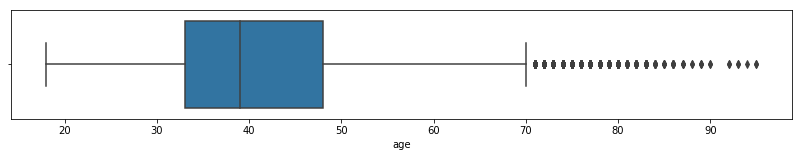

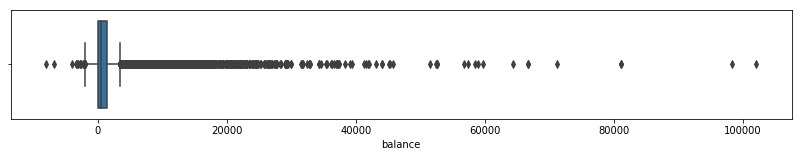

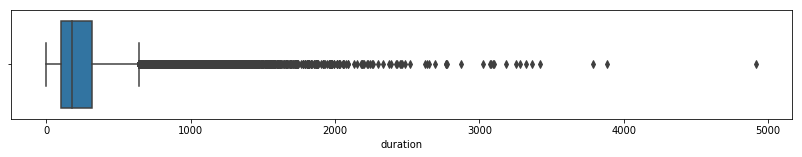

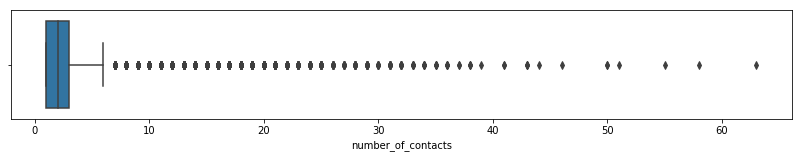

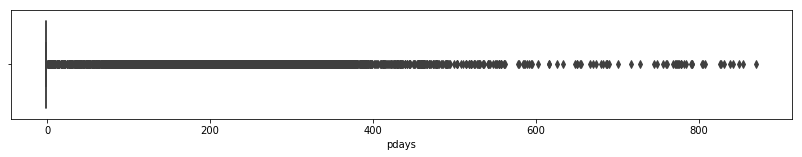

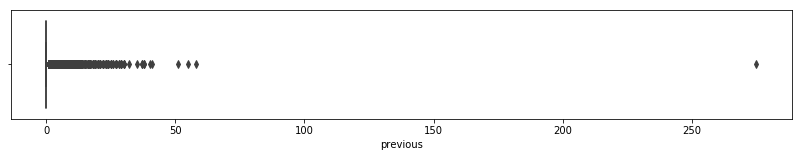

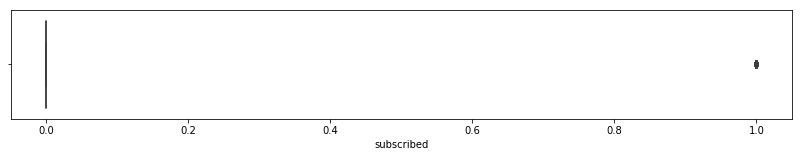

In [0]:
for x in cuantitativas:
  plt.figure(figsize=(14,2))
  sns.boxplot(bankp[x], orient='h')

**Conclusión**
La única variable donde creemos necesario quitar outliers es en la edad (en los demás simplemente vemos una distribución muy aplanada. Los quitamos mediante la función que aplica el test de Tukey.

###Eliminación outliers de 'age'

In [0]:
q1, q3 = bank.approxQuantile('age', [0.25, 0.75], 0.01)
"Cuartiles: ", q1, q3

('Cuartiles: ', 33.0, 48.0)

In [0]:
IQR = q3 - q1
"Rango intercuartílico: ", IQR

('Rango intercuartílico: ', 15.0)

In [0]:
min_thresh = q1 - 1.5 * IQR
max_thresh = q3 + 1.5 * IQR

"Umbrales de corte (inf/sup): ", min_thresh, max_thresh

('Umbrales de corte (inf/sup): ', 10.5, 70.5)

Usamos una función predefinida para quitar outliers.

In [0]:
def remove_tukey_outliers(df, col):
    """
    Returns a new dataframe with outliers removed on column 'col' usting Tukey test
    """
    
    q1, q3 = df.approxQuantile(col, [0.25, 0.75], 0.01)
    IQR = q3 - q1
    
    min_thresh = q1 - 1.5 * IQR
    max_thresh = q3 + 1.5 * IQR
    
    df_no_outliers = df.filter(F.col(col).between(min_thresh, max_thresh))
    
    return df_no_outliers

In [0]:
bank_no_outliers = remove_tukey_outliers(bank, 'age') #se quitan y el resultado va a tabla aparte.

In [0]:
n_rows_no = bank_no_outliers.count()
n_rows=bank.count()
perc_outliers = 100 * (n_rows - n_rows_no) / n_rows

In [0]:
print('{} tenía {:.2f}% outliers que se han quitado'.format('age', perc_outliers))

age tenía 1.08% outliers que se han quitado


# Correlación entre variables

**Matriz**:  miramos la correlación entre todas las variables numéricas, para ver si hay alguna dependencia mutua.

In [0]:
corr_matrix = Statistics.corr(bank_no_outliers.select(cuantitativas).rdd.map(lambda v: Vectors.dense(v)), 
                              method='pearson')
corr_matrix = pd.DataFrame(corr_matrix, columns=cuantitativas, index=cuantitativas)
corr_matrix

,age,balance,duration,number_of_contacts,pdays,previous,subscribed
age,1.000000,0.086730,-0.016260,0.012853,-0.032553,-0.009446,-0.013824
balance,0.086730,1.000000,0.019216,-0.013323,0.000433,0.013558,0.046938
duration,-0.016260,0.019216,1.000000,-0.084466,-0.002957,-0.000620,0.396874
number_of_contacts,0.012853,-0.013323,-0.084466,1.000000,-0.088477,-0.032435,-0.071690
pdays,-0.032553,0.000433,-0.002957,-0.088477,1.000000,0.454453,0.102749
previous,-0.009446,0.013558,-0.000620,-0.032435,0.454453,1.000000,0.091279
subscribed,-0.013824,0.046938,0.396874,-0.071690,0.102749,0.091279,1.000000


No observamos ninguna correlación significativa, a excepción de las variables previous y pdays.
Es decir, si esta correlación se acercara a uno se podría decir que los clientes que han sido contactados más veces son los que tienen los contactos más espaciados. Pero con un 0,45 no se puede afirmar. 

##Gráficamente

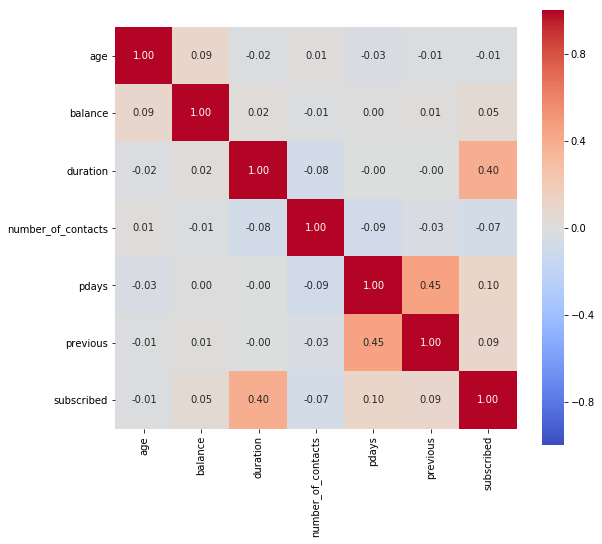

In [0]:
plt.figure(figsize=(9,8))
sns.heatmap(corr_matrix, cmap='coolwarm', vmax=1, vmin=-1, square=True, annot=True, fmt='.2f')

##Correlación respecto a la variable que recoge el resultado
Correlación respecto subscribed, que indica si al final contrató o no.





In [0]:
subs_corr = bank_no_outliers.select([F.corr(F.col('subscribed'), F.col(c)).alias(c) for c in cuantitativas])
subs_corr.toPandas().T


,0
age,-0.013824
balance,0.046938
duration,0.396874
number_of_contacts,-0.071690
pdays,0.102749
previous,0.091279
subscribed,1.000000


**Conclusión:**
La única correlación apreciable se da con la variable duration. Se confirma (en un 40% de los casos, aprox) que hay una cierta relación entre la duración de la llamada y la probabilidad de contratación, tal como indica la descripción del caso.

#Comparación entre los que contratan y los que no

**Variables**: saldo, edad, duración llamada, contactos

In [0]:
contratan=bank.filter(F.col('subscribed') ==1)
no_contratan=bank.filter(F.col('subscribed') ==0)

In [0]:
contratan.describe(cuantitativas).show()

+-------+------------------+------------------+-----------------+------------------+------------------+------------------+----------+
|summary|               age|           balance|         duration|number_of_contacts|             pdays|          previous|subscribed|
+-------+------------------+------------------+-----------------+------------------+------------------+------------------+----------+
|  count|              5288|              5288|             5288|              5288|              5288|              5288|      5288|
|   mean|41.664334341906205|1803.5283661119515|537.1830559757942|2.1405068078668683| 68.68116490166415|1.1700075642965204|       1.0|
| stddev|13.492610489467225|3501.0226867554898|392.4785809505748|1.9216054027702734|118.82292038547152|2.5533891850959654|       0.0|
|    min|                18|             -3058|                8|                 1|                -1|                 0|         1|
|    max|                95|             81204|             38

+-------+------------------+------------------+------------------+------------------+----------------+------------------+----------+
|summary|               age|           balance|          duration|number_of_contacts|           pdays|          previous|subscribed|
+-------+------------------+------------------+------------------+------------------+----------------+------------------+----------+
|  count|             39920|             39920|             39920|             39920|           39920|             39920|     39920|
|   mean| 40.83867735470942| 1303.689128256513|221.17211923847697|2.8463426853707414|36.4185120240481|0.5019038076152305|       0.0|
| stddev|10.172577192666482|2974.2565691755754|207.38228279419585|3.2128397700573954|96.7564027388835| 2.256214673893265|       0.0|
|    min|                18|             -8019|                 0|                 1|              -1|                 0|         0|
|    max|                95|            102127|              4918|   

**Variable**: presencia de impagados

In [0]:
a=contratan.filter(F.col('default') ==False).count()
b=contratan.count()
c=no_contratan.filter(F.col('default') ==False).count()
d=no_contratan.count()
a/b,c/d

(0.9901664145234493, 0.9808867735470942)

##Conclusiones
- Los que contratan suelen tener más recursos que los que no (1.800 vs 1.300)
- La llamada suele durar el doble cuando hay contratación.
- Hay pocos clientes con impagados y la incidencia de esta variable en la contratación es de un 1% (o sea, nada significativa)

